In [1]:
%matplotlib inline

In [4]:
# Run the utilities notebook
%run ./Fashion-MNIST_Utils.ipynb

OSError: /home/ubuntu/anaconda3/envs/pytorch_p36/bin/../lib/libmkldnn.so.0: undefined symbol: cblas_gemm_s8u8s32_pack

In [5]:
# Basic libs
import os, time
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

# Basic CNN Model

In [5]:
# Import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# Import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# Calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True) # on by default, leave it here for clarity

ModuleNotFoundError: No module named 'torch'

In [6]:
# Import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs


# Helper class, help track loss, accuracy, epoch time, run time, hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # Tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # Tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # Record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # Record the count, hyper-param, model, loader of each run
  # Record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

  # When run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # Zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  def end_epoch(self):
    # Calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # Record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard - DC (2019/11/26): need to fix later
#     for name, param in self.network.named_parameters():
#       self.tb.add_histogram(name, param, self.epoch_count)
#       self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # Display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # Accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # Multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # Accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # Save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [7]:
# Load the train set
trainset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

mytrainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

mytestloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Define the classes
classes = ("top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot")

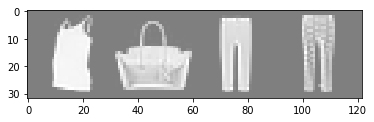

  top   bag trouser trouser


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
mydataiter = iter(mytrainloader)
myimages, mylabels = mydataiter.next()

# Show images
imshow(torchvision.utils.make_grid(myimages))

# Print labels
print(' '.join('%5s' % classes[mylabels[j]] for j in range(4)))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [9]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # Define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # Define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

mynet = Network()

In [10]:
# Put all hyper params into a OrderedDict, easily expandable
from collections  import OrderedDict

params = OrderedDict(
    lr = [.01],
    batch_size = [1000],
    shuffle = [False]
)

epochs = 5

In [11]:
import torch.optim as optim

mycriterion = nn.CrossEntropyLoss()
myoptimizer = optim.SGD(mynet.parameters(), lr=0.001, momentum=0.9)

In [12]:
%%time

# m = RunManager()

# # get all runs from params using RunBuilder class
# for run in RunBuilder.get_runs(params):

#     # if params changes, following line of code should reflect the changes too
#     network = Network()
#     myoptimizer = optim.Adam(network.parameters(), lr=run.lr)

#     m.begin_run(run, network, mytrainloader)
#     for epoch in range(epochs):
      
#       m.begin_epoch()
#       for batch in loader:
        
#         images = batch[0]
#         labels = batch[1]
#         preds = network(images)
#         loss = F.cross_entropy(preds, labels)

#         myoptimizer.zero_grad()
#         loss.backward()
#         myoptimizer.step()

#         m.track_loss(loss)
#         m.track_num_correct(preds, labels)

#       m.end_epoch()
#     m.end_run()

# # when all runs are done, save results to files
# m.save('results')

def train(trainloader):

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            myoptimizer.zero_grad()

            # forward + backward + optimize
            outputs = mynet(inputs)
            loss = mycriterion(outputs, labels)
            loss.backward()
            myoptimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    
    return outputs

myoutputs = train(mytrainloader)

[1,  2000] loss: 1.732
[1,  4000] loss: 0.860
[1,  6000] loss: 0.688
[1,  8000] loss: 0.610
[1, 10000] loss: 0.563
[1, 12000] loss: 0.538
[1, 14000] loss: 0.492
[2,  2000] loss: 0.460
[2,  4000] loss: 0.443
[2,  6000] loss: 0.425
[2,  8000] loss: 0.428
[2, 10000] loss: 0.425
[2, 12000] loss: 0.412
[2, 14000] loss: 0.397
Finished Training
CPU times: user 9min 21s, sys: 22.3 s, total: 9min 43s
Wall time: 1min 29s


In [13]:
myoutputs

tensor([[ 2.1298, -2.9707,  1.4856, -1.6293,  0.3015, -2.9478,  2.5264, -1.9543,  7.6828, -3.4233],
        [-0.1094, -1.6991,  3.4738, -0.2319,  5.1461, -3.6620,  6.1489, -3.4965, -0.6710, -4.0204],
        [ 1.5495,  1.5306, -0.1705,  6.8501,  1.6798, -4.8971,  1.7517, -4.1628, -2.1170, -2.1806],
        [-0.7981, -1.1608,  3.7781, -0.6119,  3.4060, -2.2398,  3.8984, -2.9732, -0.5258, -2.3221]],
       grad_fn=<AddmmBackward>)

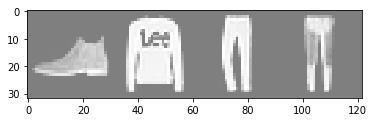

GroundTruth:  ankle boot pullover trouser trouser
Predicted  :  ankle boot pullover trouser trouser


In [14]:
mydataiter = iter(mytestloader)
myimages, mylabels = mydataiter.next()
myoutputs = mynet(myimages)
_, mypredicted = torch.max(myoutputs, 1)

# print images
imshow(torchvision.utils.make_grid(myimages))
print('GroundTruth: ', ' '.join('%5s' % classes[mylabels[j]] for j in range(4)))
print('Predicted  : ', ' '.join('%5s' % classes[mypredicted[j]] for j in range(4)))

In [15]:
%%time

def getAccuracy(testloader):

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = mynet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        correct / total * 100.))
    return correct / total * 100.
    
myaccuracy = getAccuracy(mytestloader)

Accuracy of the network on the 10000 test images: 85 %
CPU times: user 9.39 s, sys: 535 ms, total: 9.93 s
Wall time: 2.63 s


Accuracy is much better than CIFAR-10.

In [16]:
%%time

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in mytestloader:
        images, labels = data
        outputs = mynet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   top : 74 %
Accuracy of trouser : 96 %
Accuracy of pullover : 78 %
Accuracy of dress : 90 %
Accuracy of  coat : 78 %
Accuracy of sandal : 96 %
Accuracy of shirt : 63 %
Accuracy of sneaker : 89 %
Accuracy of   bag : 96 %
Accuracy of ankle boot : 97 %
CPU times: user 9.73 s, sys: 565 ms, total: 10.3 s
Wall time: 2.75 s


* Highest accuracy class: trouser
* Lowest accuracy class: shirt

## Supervised Learning & Learning Curves

In [40]:
# Use the latest ALClass notebook
%run ../ALClass.ipynb
%run Multi-gen_QS.ipynb

  ground_truth class_1  metadata_1 class_2  metadata_2 class_3  metadata_3
1  class2       class2  0.11        class2  0.09        class2  0.10      
2  NaN          class2  0.14        NaN    NaN          class2  0.17      
3  NaN          class2  0.92        class2  0.92        class2  0.92      
5  class2       class2  0.23        class2  0.10        class2  0.50      
6  NaN          class2  0.08        class2  0.01        class2  0.10      
1    0.000100
2    0.000450
3    0.000000
5    0.041633
6    0.002233
dtype: float64


Network's weights reinitialized
Training for 2000 samples:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 73.1%
Network's weights reinitialized
Training for 4000 samples:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 73.23%
Network's weights reinitialized
Training for 6000 samples:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 76.35%


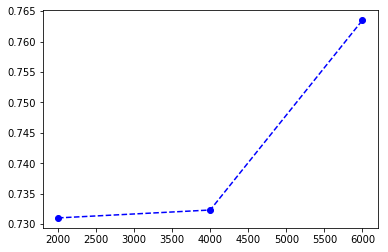

CPU times: user 9min 45s, sys: 44.5 s, total: 10min 29s
Wall time: 2min 56s


In [43]:
%%time

num_steps = 3    # <---- Play with those values. Fashion-MNIST has 48,000 records for training, and 12,000 for testing
maximum = 6000   # <----
nps = int(maximum / num_steps)

myActiveStrategy = ActiveStrategy(mynet, nsteps=num_steps)

myActiveStrategy.verbose = False

myActiveStrategy.init_loaders()
myActiveStrategy.incremental_supervised()
mySupervised = myActiveStrategy.run_experiment(num_steps, maximum)
    
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised, '--b', marker="o")
plt.show()

## Pooling Approach with Uncertainty-Based Strategy

In [44]:
%%time
import random

def confidenceAL(nsteps, stepSize):
    
    results = []
    unlabeled = [i for i in range(len(trainset))]
    labeled   = []
    
    to_be_labeled = random.sample(unlabeled, stepSize)
    to_be_labeled_set = set(to_be_labeled)
    unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled))
    
    myres = myActiveStrategy.run_one(to_be_labeled)
    results.append(myres)
    
    # Create metaDataFrame object to record metadata from the loops
    meta_df = metaDataFrame(unlabeled)
    
    for n in range(1, nsteps):
        # Fill algorithm here getting inspiration from the previous exercise
        myResults = myActiveStrategy.infer(unlabeled)
        sorted_by_conf = sorted(myResults, key=lambda x: x[3])[:stepSize] # fill here; remember that the size of the array will be 'nps'

        # Append myResults to a metadata tracking event
        meta_df.appendMetadata('confidence', n, myResults)
        
        # Update to_be_labeled:
        to_be_labeled.extend([row[0] for row in sorted_by_conf])
        to_be_labeled_set = set(to_be_labeled)
        unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update unlabeled

        myres = myActiveStrategy.run_one(to_be_labeled)
        results.append(myres)
        
    return results, meta_df
    
myConfidenceAL, myConfidenceMeta = confidenceAL(num_steps, nps)

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 73.61%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 69.77%
Network's weights reinitialized
Training for 6000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 71.72%
CPU times: user 14min 12s, sys: 37.8 s, total: 14min 50s
Wall time: 3min 7s


In [45]:
pd.set_option('display.max_colwidth', -1)
myConfidenceMeta.df

,class_1,metadata_1,class_2,metadata_2
0,ankle boot,tensor(0.9293),ankle boot,tensor(0.9333)
1,top,tensor(0.6767),top,tensor(0.4773)
3,dress,tensor(0.6363),shirt,tensor(0.3716)
4,dress,tensor(0.6876),dress,tensor(0.7827)
5,pullover,tensor(0.7723),pullover,tensor(0.5895)
6,sneaker,tensor(0.9818),sneaker,tensor(0.9349)
7,pullover,tensor(0.7304),pullover,tensor(0.4605)
8,sandal,tensor(0.9905),sandal,tensor(0.8729)
9,sandal,tensor(0.9954),sandal,tensor(0.9425)
10,top,tensor(0.8374),top,tensor(0.5697)


In [53]:
nsteps = num_steps
stepSize = nps

results = []
    
unlabeled = [i for i in range(len(trainset))]
labeled   = []

to_be_labeled = random.sample(unlabeled, stepSize)
to_be_labeled_set = set(to_be_labeled)
unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled))

myres = myActiveStrategy.run_one(to_be_labeled)
results.append(myres)
    
myResults = myActiveStrategy.infer(unlabeled)

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 71.66%


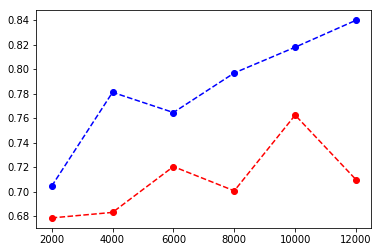

In [22]:
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,   '--b',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL, '--r',
         marker="o")

Here, the AL approach does worse than a standard supervised approach.

## Custom Querying Strategies

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 70.35%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sandal
Accuracy of the network on the 10000 test images: 63.46%
Network's weights reinitialized
Training for 6000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 48.79%
Network's weights reinitialized
Training for 8000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 69.5%
Network's weights reinitialized
Training for 10000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 67.29%
Network's weights reinitialized
Training for 12000 records:
Finished Training
GroundTruth:  ankle

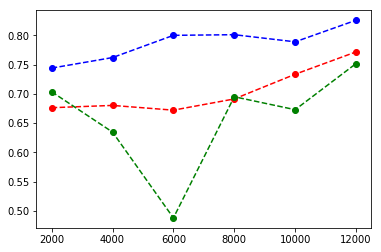

In [37]:
%%time

def update_function(inferred_res, nRec):
    ranked = sorted(inferred_res, key=lambda x: x[3])[:nRec] # Sort and select the best nRec elements
    selected = [rec[0] for rec in ranked]
    
    return selected
    
myConfidenceAL2 = myActiveStrategy.run_ConfidenceAL(update_function, num_steps, maximum)
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL,  '--r',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL2, '--g',
         marker="o")

It is interesting how you could start off similarly with the same querying strategy, but it drops to 0.5 accuracy before climbing back up.

**Q. What could cause a drop like this? It almost looks like it should be early-terminated, but it isn't.**

### Confidence Level Plot

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 71.17%
[0.963146448135376, 0.8215059041976929, 0.6443443298339844, 0.4875490367412567, 0.8856878280639648, 0.5668036341667175, 0.41956666111946106, 0.9272930026054382, 0.9625794887542725, 0.6955274939537048]
58000
CPU times: user 4min 48s, sys: 19.4 s, total: 5min 8s
Wall time: 1min 15s


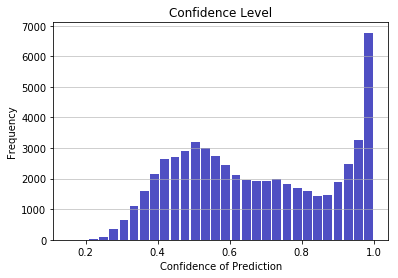

In [40]:
%%time

import random

unlabeled = [i for i in range(len(trainset))]
labeled   = []

to_be_labeled = random.sample(unlabeled, nps) # generate a random sample of the data, size nps (defined previously)
to_be_labeled_set = set(to_be_labeled)

unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update the unlabeled array once you defined to_be_labeled

myActiveStrategy.run_one(to_be_labeled)
myResults = myActiveStrategy.infer(unlabeled)

inferred_CL = [ c[3].item() for c in myResults ]
print(inferred_CL[:10])
print(len(inferred_CL))

n, bins, patches = plt.hist(x=inferred_CL, bins=30, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Confidence of Prediction')
plt.ylabel('Frequency')
plt.title('Confidence Level')
maxfreq = n.max()

plt.ylim(top=(np.ceil(maxfreq / 10) * 10 * 1.05) if maxfreq % 10 else (maxfreq + 10) * 1.05)

The distribution of confidence is completely different from CIFAR-10.
* Bi-modal distribution, highly skewed to the lower confidence but with wider distribution.
* This is looking at max confidence, perhaps a margin-based approach may work better.

### Better Confidence Level-based Strategy
Weeding out the low confidence "noise". Hold this off and run the margin-based approach first.

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 70.8%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 66.77%
Network's weights reinitialized
Training for 6000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 72.02%
Network's weights reinitialized
Training for 8000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 63.34%
Network's weights reinitialized
Training for 10000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 71.85%
Network's weights reinitialized
Training for 12000 records:
Finished Training
GroundTruth:  ankle b

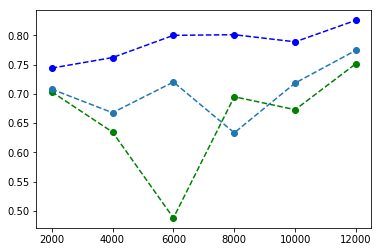

In [46]:
%%time

def update_CL_improved(inferred_res, nRec, nFilter=500): # <--- we can play with nFilter value later
    ranked = sorted(inferred_res, key=lambda x: x[3])[nFilter:]
    selected = [rec[0] for rec in ranked[:nRec]]
    
    return selected

myConfidenceAL3 = myActiveStrategy.run_ConfidenceAL(update_CL_improved, num_steps, maximum)
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL2, '--g',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL3, '--p',
         marker="o")

## Streaming Approach with Uncertainty-Based Strategy

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 68.57%
Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 74.38%
Network's weights reinitialized
Training for 2001 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  ankle boot
Accuracy of the network on the 10000 test images: 67.85%
Network's weights reinitialized
Training for 2001 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sandal
Accuracy of the network on the 10000 test images: 70.12%
Network's weights reinitialized
Training for 2001 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 71.33%
Network's weights reinitialized
Training for 2001 records:
Finished Training
GroundTruth:  ankle 

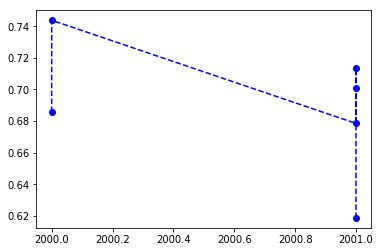

In [42]:
%%time

def update_streaming(inferred_res, threshold=0.15):
    next_loop = sorted(x[0] for x in inferred_res if x[3] < threshold)
    
    return next_loop
    
myStreamingAL, myStepSizes = myActiveStrategy.run_StreamingAL(update_streaming, num_steps, maximum)
plt.plot(myStepSizes, myStreamingAL , '--b', marker="o")

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sandal
Accuracy of the network on the 10000 test images: 71.8%
0.36392215788364407
Network's weights reinitialized
Training for 4900 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sandal
Accuracy of the network on the 10000 test images: 56.49%
0.33600768595933916
Network's weights reinitialized
Training for 7655 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 70.29%
0.39342633485794065
Network's weights reinitialized
Training for 10273 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sandal
Accuracy of the network on the 10000 test images: 68.81%
0.376929622888565


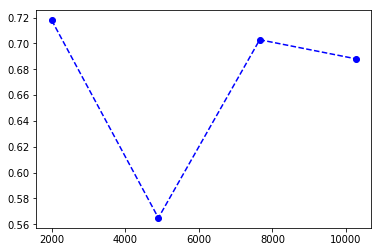

In [43]:
def update_streaming_perc(inferred_res, threshold=5): # <-- here, threshold is the amount of data we want to keep
    # Using the np.percentile function, fill the function
    perc = np.percentile([x[3] for x in inferred_res], threshold)
    print(perc)
    next_loop = sorted(x[0] for x in inferred_res if x[3] < perc)
    
    return next_loop
    
myStreamingAL2, myStepSizes2 = myActiveStrategy.run_StreamingAL(update_streaming_perc, num_steps, maximum)
plt.plot(myStepSizes2, myStreamingAL2 , '--b', marker="o")

**We are seeing the drop around 5000 data points again, it seems like it happens around the first "peak."**

## Margin Sampling-Based Strategy

In [44]:
%%time
import operator

# Explain what this function does...
def update_margin(inferred_res, nRec):
    for k in range(len(inferred_res)):
        # Margin difference in confidence between the most confident classes
#         inferred_res[k].extend(zip(*sorted(enumerate(inferred_res[k]), key=operator.itemgetter(1)))[0][-2:])
        inferred_res[k].extend(list(zip(*sorted(enumerate(inferred_res[k][4]), key=operator.itemgetter(1))))[1][-2:])
    
#     ranked = sorted(inferred_res, key=lambda x: x[5] - x[4], reverse=False)[:nRec]
    ranked = sorted(inferred_res, key=lambda x: x[6] - x[5], reverse=False)[:nRec] # margin low to high
    selected = [rec[0] for rec in ranked]
    
    return selected

myConfidenceAL4 = myActiveStrategy.run_ConfidenceAL(update_margin, num_steps, maximum)

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 73.35%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sandal
Accuracy of the network on the 10000 test images: 60.61%
Network's weights reinitialized
Training for 6000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 77.5%
Network's weights reinitialized
Training for 8000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 79.21%
Network's weights reinitialized
Training for 10000 records:
Finished Training
GroundTruth:  ankle boot
Predicted:  sneaker
Accuracy of the network on the 10000 test images: 73.36%
Network's weights reinitialized
Training for 12000 records:
Finished Training
GroundTruth:  ankle boot
Pre

NameError: name 'myConfidenceAL3' is not defined

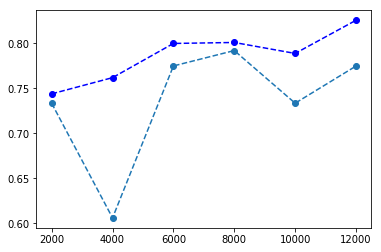

In [45]:
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
#          [nps*i for i in range(1, num_steps + 1)], myConfidenceAL3, '--g',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL4, '--p',
         marker="o")

## Query-By-Committee Strategies

Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:   frog
Accuracy of the network on the 10000 test images: 25.0%
Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 23.73%
Network's weights reinitialized
Training for 2000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 28.23%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on the 10000 test images: 26.44%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    dog
Accuracy of the network on the 10000 test images: 28.11%
Network's weights reinitialized
Training for 4000 records:
Finished Training
GroundTruth:    cat
Predicted:    cat
Accuracy of the network on

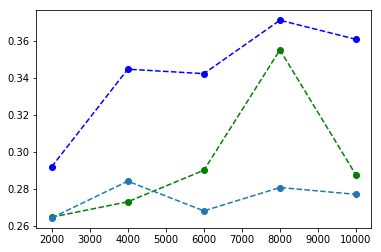

In [52]:
def QbCAL(nsteps, stepSize):
    
    results = []
    
    unlabeled = [i for i in range(len(trainset))]
    labeled   = []

    # Randomly sample what is to be labeled first...
    to_be_labeled = random.sample(unlabeled, stepSize)
    unlabeled = [i for i in range(len(unlabeled)) if i not in to_be_labeled]
    
    for n in range(0, nsteps):
        # Fill the function by following the same logic that previously within a loop
        myAccuracy1 = myActiveStrategy.run_one(to_be_labeled)
        myResults1  = myActiveStrategy.infer(unlabeled)
        myAccuracy2 = myActiveStrategy.run_one(to_be_labeled)
        myResults2  = myActiveStrategy.infer(unlabeled)
        myAccuracy3 = myActiveStrategy.run_one(to_be_labeled)
        myResults3  = myActiveStrategy.infer(unlabeled)
        
        disagreement = []

        for r in range(len(unlabeled)):
            dis = 0
            if myResults1[r][2] != myResults2[r][2]:
                dis += 1
            if myResults2[r][2] != myResults3[r][2]:
                dis += 1
            if myResults1[r][2] != myResults3[r][2]:   
                dis += 1
            disagreement.append(dis)
        
        sorted_by_disagree = sorted(zip(myResults1, disagreement), key=lambda x: x[1], reverse=True)[:stepSize] # fill here; remember that the size of the array will be 'nps'

        # update to_be_labeled:
        to_be_labeled.extend([x[0] for x in [row[0] for row in sorted_by_disagree]])
        to_be_labeled_set = set(to_be_labeled)
        unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update unlabeled

        myres = myActiveStrategy.run_one(to_be_labeled)
        results.append(myres)        
        
    return results
    
myQbCAL = QbCAL(num_steps, nps)

plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
         [nps*i for i in range(1, num_steps + 1)], myConfidenceAL4, '--g',
         [nps*i for i in range(1, num_steps + 1)], myQbCAL,         '--p',
         marker="o")

Observations:
* QbC is a lot more stable, but does not result in significant improvements like the other methodologies.
* Q. When should QbC used? Doesn't it defeat the purpose of AL since it is training multiple classifiers?